<a href="https://colab.research.google.com/github/Roopana/TwitterAdAnalysis/blob/master/sb_classical_baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://www.kdnuggets.com/2018/11/multi-class-text-classification-model-comparison-selection.html/2

In [ ]:
# Naive Bayes Classifier for Multinomial Models

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

print('done')

done


In [ ]:
import pandas as pd
import numpy as np

df_2 = pd.read_csv("./2_man_ann_sb.csv",  index_col= None)
df_2 = df_2.dropna(subset = ['tweet_text'])

df_1 = pd.read_csv("./mann_ann_sb.csv", index_col= None)

df_3 = pd.read_csv("./3_man_ann_sb_full_1.csv", index_col = None)
df_3 = df_3.dropna(subset = ['tweet_text'])

df_raw = df_1.append(df_2).append(df_3) # using batch 1 and batch 2 for training
df = df_raw
df_raw.shape

(7500, 19)

Data Cleaning

In [ ]:
# Remove ads marked as below because they are not available in ad annotations file although tweets mention them
# commercials, joe biden, pizzahut, joe bieden, michael bloomberg, mike bloomberg, scientology...
ads_remove = ['commercials', 'joe biden', 'pizzahut', 'joe bieden', 'michael bloomberg', 'mike bloomberg', 
              'scientology','papa johns',  'bakari',  'secret', 'dashlane', 'bernie the peoples perfume',
              'ram trucks', 'golden gronks', "bush's best", 'ragged old flag', 'patience', 'guitar hero',
              'disney mulan']

# ads_rename = ['nfl100', 'tide']

# rename ads with spelling faults while manually adding the annotation 

df_raw['ad_manual_adjusted'] = df_raw['ad_manual_adjusted'].apply(lambda x: x.lower())
df_raw.loc[df_raw.ad_manual_adjusted == "discover card  no we don‚äôt charge annual fees", 
       "ad_manual_adjusted"] = "discover card  no we don’t charge annual fees"
df_raw.loc[df_raw.ad_manual_adjusted == "doritos the cool ranch", 
       "ad_manual_adjusted"] = "doritos  the cool ranch"
df_raw.loc[df_raw.ad_manual_adjusted == "discover card yes we're accepted", 
       "ad_manual_adjusted"] =  "discover card  yes we’re accepted"
df_raw.loc[df_raw.ad_manual_adjusted == "discover card yes we’re accepted", 
       "ad_manual_adjusted"] =  "discover card  yes we’re accepted"
df_raw.loc[df_raw.ad_manual_adjusted == "discover card  yes we're accepted", 
       "ad_manual_adjusted"] =  "discover card  yes we’re accepted"
df_raw.loc[df_raw.ad_manual_adjusted == "budweiser typical american", 
       "ad_manual_adjusted"] = "budweiser  typical american"
df_raw.loc[df_raw.ad_manual_adjusted == 'fox  halftime show  teaser_3',
            "ad_manual_adjusted"] = "fox  halftime show  teaser_1"

print(df_raw.shape)
df = pd.DataFrame()
removed_Data = pd.DataFrame()

for i,row  in df_raw.iterrows():
  if row['ad_manual_adjusted'] not in ads_remove:
    df = df.append(row)
  else:
    removed_Data = removed_Data.append(row)
print(df.shape)


(7500, 19)
(7394, 19)


In [ ]:
from nltk.corpus import stopwords
import re
import nltk
nltk.download('stopwords')

# stop = stopwords.words('english')
stop = []
stop.append('superbowl')
stop.append('super')
stop.append('bowl')
stop.append('commercial')
stop.append('ad')
stop.append('commercials')
stop.append('ads')

print(len(stop))

def removeMentions(text):

    textBeforeMention = text.partition("@")[0]
    textAfterMention = text.partition("@")[2]
    textAfterMention =  re.sub(r':', '', textAfterMention) #cadillac join the 31k
    tHandle = textAfterMention.partition(" ")[0].lower() #cadillac    
    text = textBeforeMention+ " " + textAfterMention  
    return text

def cleanTweet(strinp):
    strinp = re.sub(r'RT', "", strinp) # Remove RT
    strinp = strinp.lower()
    
    stop_removed_list = [word for word in strinp.split() if word not in (stop)]
    stop_removed = ' '.join([str(elem) for elem in stop_removed_list])    
    text = re.sub('https?://[A-Za-z0-9./]+', ' ', stop_removed) # Remove URLs
    text = removeMentions(text)
    text = re.sub('[^\x00-\x7F]+', ' ', text) # Remove non-ASCII chars.
    
    # remove punctuations except '-'
    punctuation = ['(', ')', '[',']','?', ':', ':', ',', '.', '!', '/', '"', "'", '@', '#', '&', '-', '_']
    text = "".join((char for char in text if char not in punctuation))
    text = re.sub('[^a-zA-Z]', ' ', text) # remove all other than alphabet chars 

#     text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text) # remove all single characters     
    stop_removed_l = [word for word in text.split() if word not in (stop)]
    stop_removed = ' '.join([str(elem) for elem in stop_removed_l]) 
    return stop_removed

print(cleanTweet("RT @cadillacabc: Joinrt the 31K james_bond") )

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
7
cadillacabc joinrt the k jamesbond


In [ ]:
df['text_clean'] = df['tweet_text'].apply(lambda x: cleanTweet(x))
df['ad_manual_adjusted'] = df['ad_manual_adjusted'].apply(lambda x: x.lower())
df['ad_related'] = df['ad_manual_adjusted'].apply(lambda x: 0 if x == 'none' else 1)

filter_comma_ads = True
if filter_comma_ads:
  df = df[~df['ad_manual_adjusted'].str.contains(",")]
print(df.shape)

(7332, 21)


In [ ]:
ad_product_df = pd.read_csv('./SB_ad_annotations_product_category_modified.csv')
ad_product_df = ad_product_df.rename(columns = {'Ad Name': 'Ad_Name'}) # rename the column to remove space
ad_product_df = ad_product_df.dropna() # because the file has trailing empty rows, remove them
ad_product_dict = dict()

for i, row in ad_product_df.iterrows():
  ad_product_dict[row['Ad_Name'].lower()] = row['Product_modified'].lower()

ad_product_dict['none'] = 'none'

print(ad_product_dict)

df['product_modified'] = df['ad_manual_adjusted'].apply(lambda ad: ad_product_dict[ad])

{'fast & furious 9  trailer': 'movie trailer', 'quibi  bank heist': 'tech company', 'tide  when is later  masked singer': 'laundry detergent', 'fox  a run at history  daytona 500': 'sporting event', 'donald j. trump for president  criminal justice reform': 'political campaign', 'walmart  famous visitors': 'tech company', 'marvel  black widow trailer': 'movie trailer', 'rocket mortgage  home': 'money', 'porsche  the heist': 'car', 'snickers  fix the world': 'food', 'hulu  tom brady s big announcement': 'streaming service', 'fox  chosen  lego masters': 'tv show/network', 'mountain dew': 'pop/soda', 'squarespace  winona in winona': 'tech company', 'new york life  love takes action': 'money', 'fox  super monday': 'tv show/network', 'hyundai  smaht pahk': 'car', 'cheetos  can t touch this': 'food', 'olay  make space for women': 'charitable program', 'fox  halftime show  teaser_1': 'half-time show', 'michelob  6 for 6-pack': 'charitable program/ alcohol', 'avocados from mexico  the avocados 

In [ ]:
product_id_dict = dict()
products = df['product_modified'].unique()
i=0

for product in products:
  product_id_dict[product] = i
  i = i+1

n_unique_ad_produts = len(product_id_dict)

if classification_ad_product:
  n_unique_ads = n_unique_ad_produts

df['ad_product_id'] = df['product_modified'].apply(lambda x: product_id_dict[x])

print(n_unique_ads)

20


In [ ]:
# Remove ads with less than 2 samples

def getAdTweets(ad_related_twts, ad):
  return ad_related_twts[ad_related_twts.ad_manual_adjusted == ad].shape[0]

def get_filtered_data(df): 
  unique_ads = df['ad_manual_adjusted'].unique()
  print(unique_ads)
  for ad in unique_ads : 
    if getAdTweets(df, ad) >=2:
        # do nothing
        print("")
    else:
      # print('ad with <2 samples: '+ str(ad))
      mask = df['ad_manual_adjusted'] != ad
      df = df[mask]
  return df

df = get_filtered_data(df)
print('Removed tweets for ads with <2 samples')

In [ ]:
# #Let us try some sampling technique to remove class imbalance
# from imblearn.over_sampling import SMOTE
# #Over-sampling: SMOTE
# #SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, 
# #based on those that already exist. It works randomly picking a point from the minority class and computing 
# #the k-nearest neighbors for this point.The synthetic points are added between the chosen point and its neighbors.
# #We'll use ratio='minority' to resample the minority class.
# smote = SMOTE('minority', k_neighbors = 3) # default value of n_neighbours = 6, but getting error since for a class n samples = 4 < default n_neighs which is 6

# input_data_raw = df['text_clean']
# input_labels_raw = df['ad_product_id']
# input_data, input_labels = smote.fit_sample(input_data_raw, input_labels_raw)
# print(input_data.shape, input_labels.shape)

In [ ]:
classification_ad_product = True # enable this flag if labels are ad products(i.e buckets of ad names) instead of ad names


In [ ]:
if classification_ad_product:
  twt_train, twt_test, label_train, label_test = train_test_split(df['text_clean'], 
                                                      df['product_modified'], test_size=0.2, random_state=42
                                                      , stratify= df.ad_manual_adjusted.values)
  unique_ads = df['product_modified'].unique()
  print("No of Unique ads:"+ str(len(unique_ads)))
else:
  twt_train, twt_test, label_train, label_test = train_test_split(df['text_clean'], 
                                                      df['ad_manual_adjusted'], test_size=0.2, random_state=42
                                                      , stratify= df.ad_manual_adjusted.values)
  unique_ads = df['ad_manual_adjusted'].unique()
  print("No of Unique ads:"+ str(len(unique_ads)))


No of Unique ads:20


In [ ]:

# print(unique_ads)

Naive Bayes Classifier for Multinomial Models

In [ ]:

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(twt_train, label_train)

label_pred_nb = nb.predict(twt_test)


print('accuracy %s' % accuracy_score(label_pred_nb, label_test))
classification_report_nb = classification_report(label_test, label_pred_nb, target_names= set(label_test),output_dict=True)
classification_report_nb_df = pd.DataFrame(classification_report_nb).transpose()
classification_report_nb_df.to_csv('./classification_report_nb.csv')


accuracy 0.6186903137789904


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Linear Support Vector Machine


In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(twt_train, label_train)

label_pred_sgd = sgd.predict(twt_test)

print('accuracy %s' % accuracy_score(label_pred_sgd, label_test))
classification_report_sgd = classification_report(label_test, label_pred_sgd, target_names= set(label_test), output_dict=True)
classification_report_sgd_df = pd.DataFrame(classification_report_sgd).transpose()
classification_report_sgd_df.to_csv('./classification_report_sgd.csv')

accuracy 0.8178717598908595


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(twt_train, label_train)

label_pred_logreg = logreg.predict(twt_test)

print('accuracy %s' % accuracy_score(label_pred_logreg, label_test))
classification_report_logreg = classification_report(label_test, label_pred_logreg, target_names= set(label_test), output_dict=True)
classification_report_logreg_df = pd.DataFrame(classification_report_logreg).transpose()
classification_report_logreg_df.to_csv('./classification_report_logreg.csv')

accuracy 0.8519781718963165


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Normalized confusion matrix


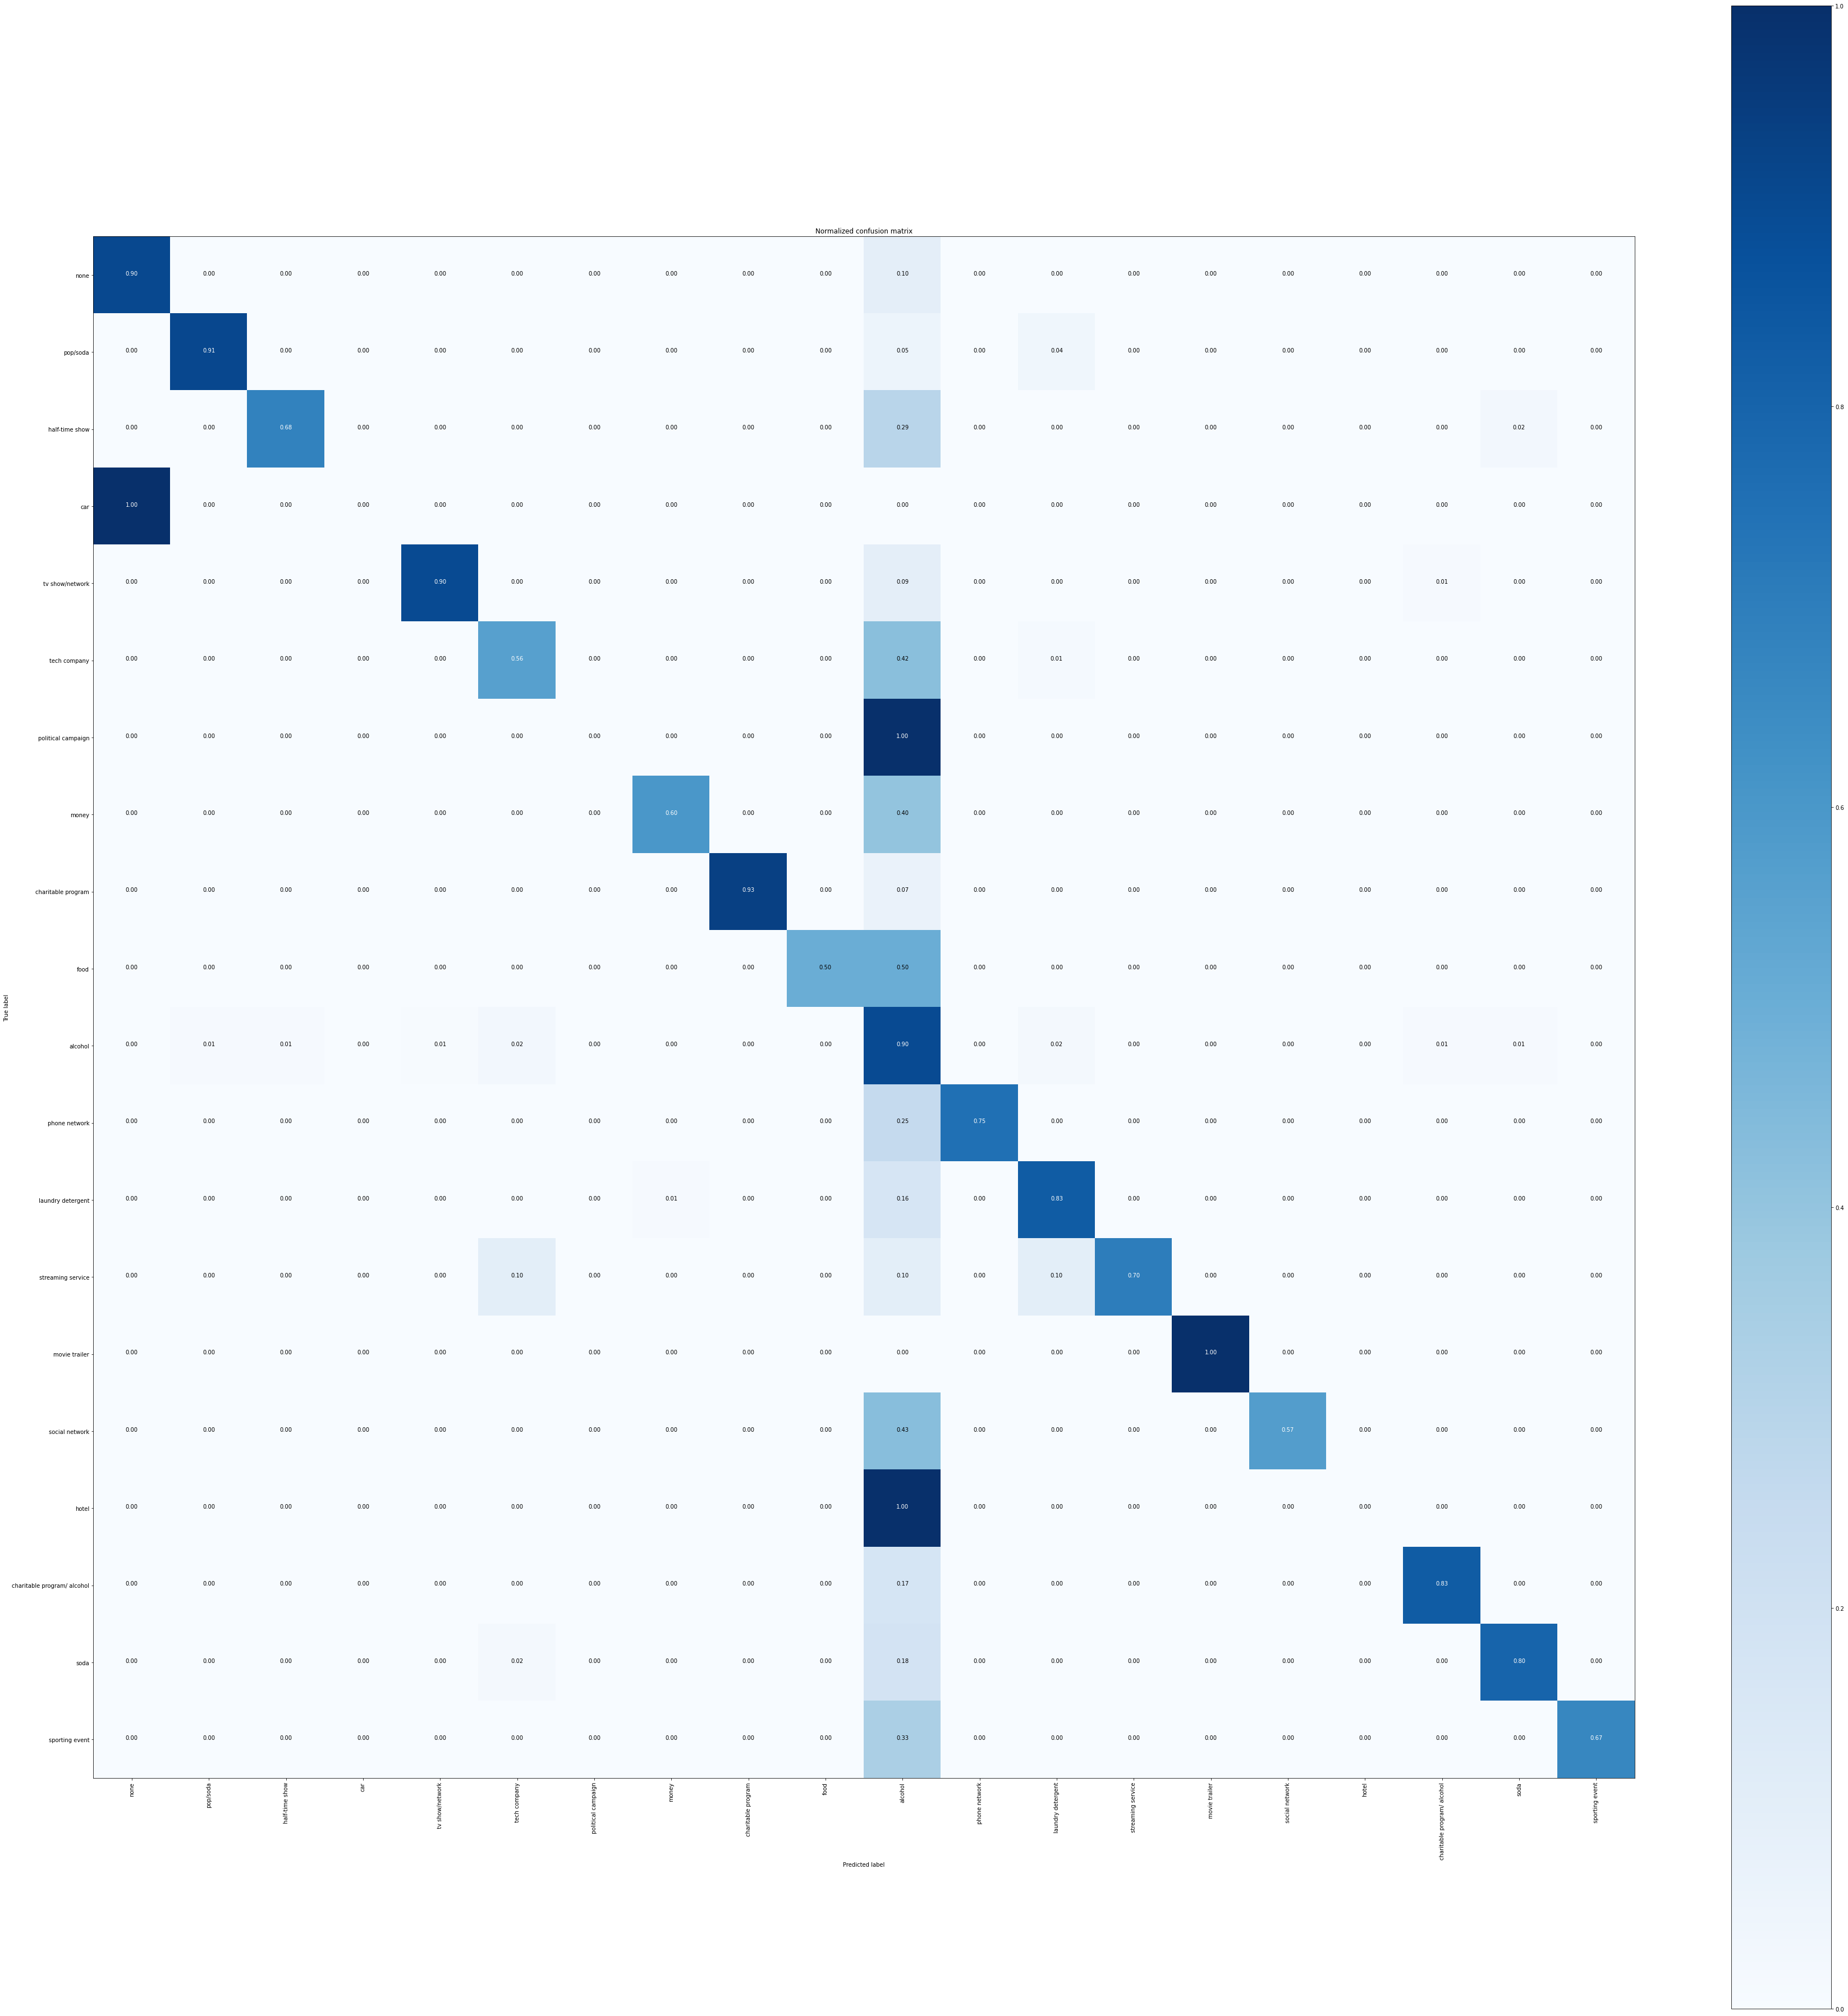

In [ ]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = label_pred_logreg
cnf_matrix = confusion_matrix(label_test, y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(50, 50, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(unique_ads), normalize=True,
                      title='Normalized confusion matrix')